## Implementing SPADE Algo


In [1]:
import bokeh
from bokeh.plotting import show
import matplotlib.pyplot as plt

import flowkit as fk

bokeh.io.output_notebook()
%matplotlib inline

_ = plt.ioff()

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import numpy as np

Loading BokehJS ...

Importing the fcs object using path

In [2]:
fcs_path = 'nbt.1991-SD1.fcs'

In [3]:
sample = fk.Sample(fcs_path, ignore_offset_error=True)
#sample = fk.Sample.__init__(self=fcs_path,fcs_path_or_data=fcs_path, sample_id='nbt')

/Users/ccc14/miniforge3/lib/python3.10/site-packages/flowio/flowdata.py:344: UserWarning: FCS file nbt.1991-SD1.fcs reported incorrect data offset. Attempting to parse data section, but event data should be reviewed before trusting this file.
  warn(warn_msg)


In [4]:
sample

Sample(v3.0, nbt.1991-SD1.fcs, 2 channels, 50000 events)

In [5]:
sample.pns_labels

['marker1', 'marker2']

In [6]:
p = sample.plot_scatter(
    'marker1', 'marker2',
    source='raw', y_min=0., y_max=130, x_min=0., x_max=280, color_density=True
)

In [7]:
show(p)

In [8]:
logicle_xform = fk.transforms.LogicleTransform('logicle', param_t=262144, param_w=0.5, param_m=4.5, param_a=0)
sample.apply_transform(logicle_xform)

p = sample.plot_scatter(1, 2, source='xform', subsample=True)
show(p)

In [9]:
asinh_xform = fk.transforms.AsinhTransform('asinh', param_t=262144, param_m=4.5, param_a=2.0)
sample.apply_transform(asinh_xform)

p = sample.plot_scatter(1, 2, source='xform', subsample=True)
show(p)

### Density dependent downsampling

Using pseudocode from Qiu, P., Simonds, E., Bendall, S. et al. Extracting a cellular hierarchy from high-dimensional cytometry data with SPADE. Nat Biotechnol 29, 886–891 (2011). https://doi.org/10.1038/nbt.1991 (https://static-content.springer.com/esm/art%3A10.1038%2Fnbt.1991/MediaObjects/41587_2011_BFnbt1991_MOESM15_ESM.pdf)

"SPADE views a cytometry data set as a high-dimensional point cloud, where each point in the cloud is one cell and the dimension of the cloud is the number of cellular markers. Dense regions of the cloud correspond to abundant cell types, whereas low-density regions correspond to rare cell types or cells in transition between abundant cell types. Most clustering algorithms rely on the density variation to identify abundant cell types6,7,8,9,10,12. In contrast, SPADE down-samples the data in a density-dependent fashion to remove the density variation."

Pseudocode:

![Screenshot 2023-07-05 at 10.34.34 AM.png](<attachment:Screenshot 2023-07-05 at 10.34.34 AM.png>)

(transform data here if needed)
We will take a random 2000 events using subsampling, calculate the distance of each of their nearest neighbour, take median of these distances and store it

In [12]:
sample.subsample_events(subsample_count=2000)

In [13]:
sample.subsample_indices

array([26247, 35067, 34590, ..., 45205,  7119,   231])

In [17]:
np_events = sample.get_events(source='xform', subsample=2000)

In [18]:
np_events.shape

(2000, 2)

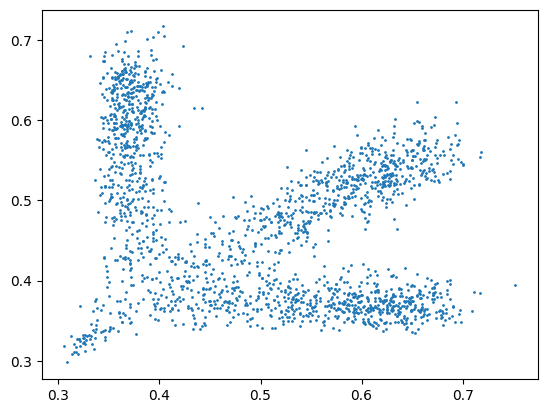

In [22]:
plt.scatter(*np_events.T, s=1)
plt.show()

In [78]:
np_events = sample.get_events(source='raw')
channel_labels = sample.pnn_labels
sample_from_np = fk.Sample(np_events, channel_labels=channel_labels, sample_id='my_sample_from_numpy')
sample_from_np


Sample(v3.1, my_sample_from_numpy, 2 channels, 50000 events)

In [24]:
np_events.shape

(2000, 2)

Finding nearest neighbour of all subsample events (storing distance and indices using sklearn)

In [48]:
NearestNeighbors?

In [56]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(np_events)

In [57]:
distances, indices = nbrs.kneighbors(np_events)

In [58]:
distances


array([[0.        , 0.00233383],
       [0.        , 0.00122955],
       [0.        , 0.00320355],
       ...,
       [0.        , 0.00231207],
       [0.        , 0.01283119],
       [0.        , 0.00136582]])

storing median distance of all nearest neighbours

In [59]:
med_min_dist = np.median(distances, axis=0)[1]

In [60]:
med_min_dist

0.0027138041355205373

In [61]:
alpha = 5
dist_threshold = med_min_dist * alpha

In [62]:
dist_threshold

0.013569020677602687

Calculating all neighbours for all events using `dist_threshold` radius neighbour classifier

In [63]:
events = sample.get_events(source='xform')
events.shape

(50000, 2)

In [64]:
neighbours = nbrs.radius_neighbors(events, radius=dist_threshold, return_distance=False)

Storing the number of neighbours in each event's `dist_threshold` radius distance as `local_density` array

In [69]:
local_density = np.empty(0)
for x in range(neighbours.size):
    local_density = np.append(local_density, neighbours[x].size)

In [70]:
local_density

array([12., 20., 21., ..., 44., 15.,  8.])

In [74]:
local_density.shape

(50000,)

Calculating the probability of keeping cell `i` in array `keep_cell_prob` using equation(i) in Qui et. al 


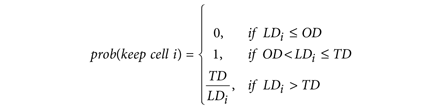

In [71]:
np.percentile(local_density, 1)

1.0

In [99]:
np.percentile(local_density, 2)

2.0

In [113]:
keep_cell_prob = np.empty(0)
outlier_density = np.percentile(local_density, 1)
target_density = np.percentile(local_density, 3)
for x in range(local_density.size):
    if local_density[x] <= outlier_density:
        keep_cell_prob = np.append(keep_cell_prob, 0)
    elif (outlier_density < local_density[x]) & (local_density[x] <= target_density):
        keep_cell_prob = np.append(keep_cell_prob,1)
    else:
        keep_cell_prob = np.append(keep_cell_prob, (target_density/local_density[x]))


Using `keep_cell_prob` to determine outcome of keeping event for clustering

In [114]:
import random
keep_cell = np.empty(0)
def event_trial(cell_prob):
    if random.random() <= cell_prob:
        return 0
    else:
        return 1
    
for x in range(keep_cell_prob.size):
    keep_cell = np.append(keep_cell, event_trial(keep_cell_prob[x]))


In [115]:
kept_events = events[keep_cell.astype('bool'), :]

In [116]:
kept_events.shape

(42343, 2)

In [120]:
import scipy as sp

In [135]:
X1 = kept_events[::10]
kernel = sp.stats.gaussian_kde(X1)
Z_kept = np.reshape(kernel().T, X1.shape)

LinAlgError: 4-th leading minor of the array is not positive definite

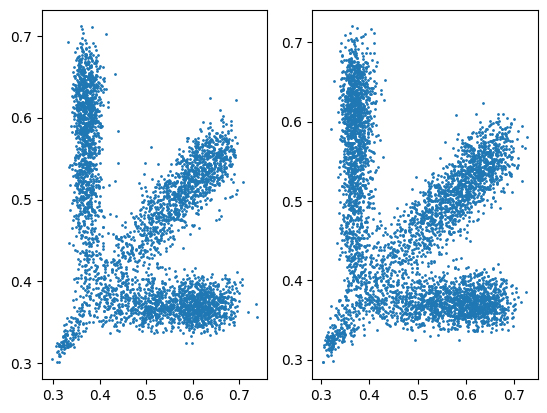

In [130]:
plt.subplot(1,2,1)
plt.scatter(*kept_events[::10].T, s=1)


plt.subplot(1,2,2)
plt.scatter(*events[::10].T, s=1)
plt.show()

In [104]:
keep_cell

array([1., 0., 1., ..., 1., 1., 1.])

In [91]:
downsample_indices = np.empty(0)
for x in range(keep_cell.size):
    if keep_cell[x]==1:
        downsample_indices = np.append(downsample_indices,x)

downsample_indices.size

29971

### Aglomerative Clustering